/var/tmp/lazin1/ipykernel_1408782/618111624.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start=start_time, periods=num_bands, freq="3H")


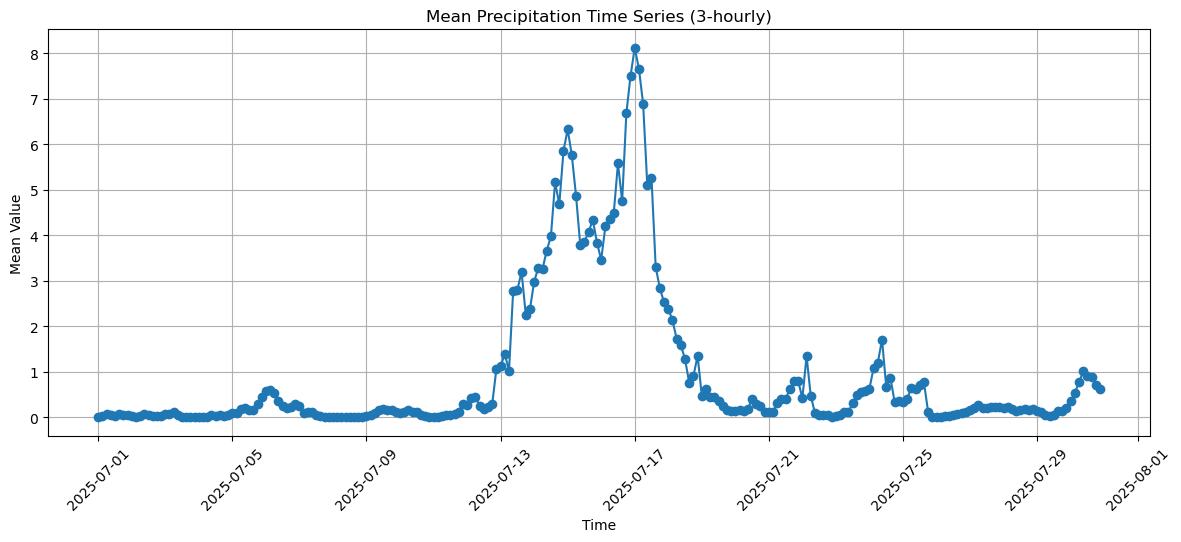

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Path to your multi-band GeoTIFF ---
tiff_path = "/p/lustre2/lazin1/IMERG/precip_IMERG_GuadalupeRiver.tif"

# --- Define start time ---
start_time = pd.Timestamp("2025-07-01 00:00")  # Adjust if needed

# --- Read data and compute mean per band ---
with rasterio.open(tiff_path) as src:
    num_bands = src.count
    mean_series = []

    for band in range(1, num_bands + 1):
        data = src.read(band).astype(np.float32)

        if src.nodata is not None:
            data = np.where(data == src.nodata, np.nan, data)

        mean_value = np.nanmean(data)
        mean_series.append(mean_value)

# --- Create datetime index for 3-hour steps ---
time_index = pd.date_range(start=start_time, periods=num_bands, freq="3H")

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.plot(time_index, mean_series, marker='o', linestyle='-')
plt.title("Mean Precipitation Time Series (3-hourly)")
plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


Total bands: 240


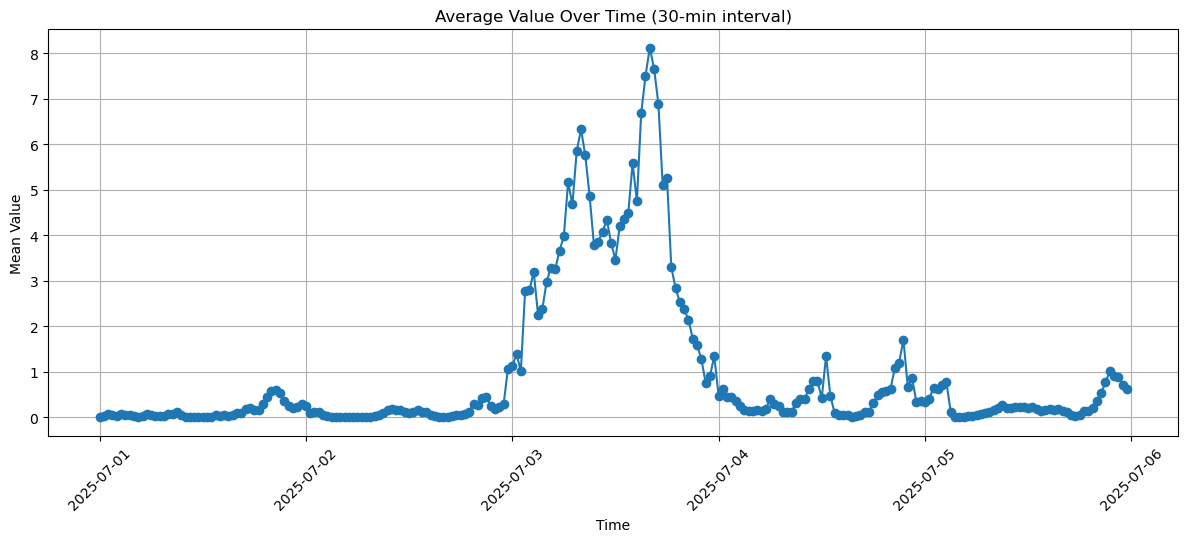

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import datetime

# === Configuration ===
tiff_path = "/p/lustre2/lazin1/IMERG/precip_IMERG_GuadalupeRiver.tif"# replace with actual path
start_datetime = datetime.datetime(2025, 7, 1, 0, 0)  # adjust based on the file
time_interval = datetime.timedelta(minutes=30)  # 30-minute interval

# === Read raster data ===
with rasterio.open(tiff_path) as src:
    num_bands = src.count
    print(f"Total bands: {num_bands}")

    # Pre-allocate time series
    mean_vals = []

    for i in range(1, num_bands + 1):
        band = src.read(i)
        # Masked mean to avoid no-data values
        band_mean = np.nanmean(np.where(band == src.nodata, np.nan, band))
        mean_vals.append(band_mean)

# === Create time series axis ===
time_axis = [start_datetime + i * time_interval for i in range(num_bands)]

# === Plot ===
plt.figure(figsize=(12, 5))
plt.plot(time_axis, mean_vals, marker='o')
plt.title("Average Value Over Time (30-min interval)")
plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [11]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.transform import from_origin
import glob
import os
from tqdm import tqdm

# === Parameters ===
input_dir = "/p/lustre2/lazin1/hrrr_conus_apcp_20250701_20250710"
output_file = "/p/lustre2/lazin1/hrrr_conus_apcp_20250701_20250710/HRRR_APCP_20250701_20250710_multiband.tif"

# === Get sorted GRIB2 files ===
grib_files = sorted(glob.glob(os.path.join(input_dir, "HRRR_APCP_CONUS_202507*.grib2")))

# === Read and process all bands ===
bands = []
lat, lon = None, None

for file in tqdm(grib_files, desc="Processing GRIB2 files"):
    ds = xr.open_dataset(file, engine='cfgrib')

    # Select precipitation variable
    if "tp" in ds:
        precip = ds["tp"]
    elif "APCP_surface" in ds:
        precip = ds["APCP_surface"]
    else:
        varname = list(ds.data_vars)[0]
        precip = ds[varname]

    # Extract 2D array
    if "time" in precip.dims:
        precip = precip.isel(time=0)

    data = precip.values

    # Flip lat if needed
    if lat is None:
        lat = ds.latitude.values
        lon = ds.longitude.values
        flip = True#np.all(np.diff(lat) < 0)

    if flip:
        data = np.flipud(data)

    bands.append(data)

# === Create GeoTIFF ===
bands = np.stack(bands, axis=0)

# Define transform
pixel_size_x = abs(lon[1] - lon[0])
pixel_size_y = abs(lat[1] - lat[0])
# transform = from_origin(west=lon.min(), north=lat.max(), xsize=pixel_size_x, ysize=pixel_size_y)

import numpy as np
from rasterio.transform import from_bounds

# lat and lon are 2D arrays of shape (1059, 1799)
# Get bounding coordinates
lat_min = np.min(lat)
lat_max = np.max(lat)

# Convert longitudes from 0–360 to -180–180
lon_corrected = np.where(lon > 180, lon - 360, lon)

# Check the new bounds
print("Corrected Lon bounds:", np.min(lon_corrected), np.max(lon_corrected))

lon_min = np.min(lon_corrected)
lon_max = np.max(lon_corrected)

height, width = lat.shape

# Create the affine transform from bounds (this assumes uniform spacing!)
transform = from_bounds(lon_min, lat_min, lon_max, lat_max, width, height)



with rasterio.open(
    output_file, 'w',
    driver='GTiff',
    height=bands.shape[1],
    width=bands.shape[2],
    count=bands.shape[0],
    dtype=bands.dtype,
    crs='EPSG:4326',
    transform=transform
) as dst:
    for i in range(bands.shape[0]):
        dst.write(bands[i], i + 1)

print(f"✅ Multi-band GeoTIFF saved: {output_file}")


Processing GRIB2 files:   0%|          | 0/240 [00:00<?, ?it/s]/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Processing GRIB2 files:   1%|          | 2/240 [00:00<00:13, 17.60it/s]/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a futur

Corrected Lon bounds: -134.09547973426314 -60.91719277183779
✅ Multi-band GeoTIFF saved: /p/lustre2/lazin1/hrrr_conus_apcp_20250701_20250710/HRRR_APCP_20250701_20250710_multiband.tif


/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


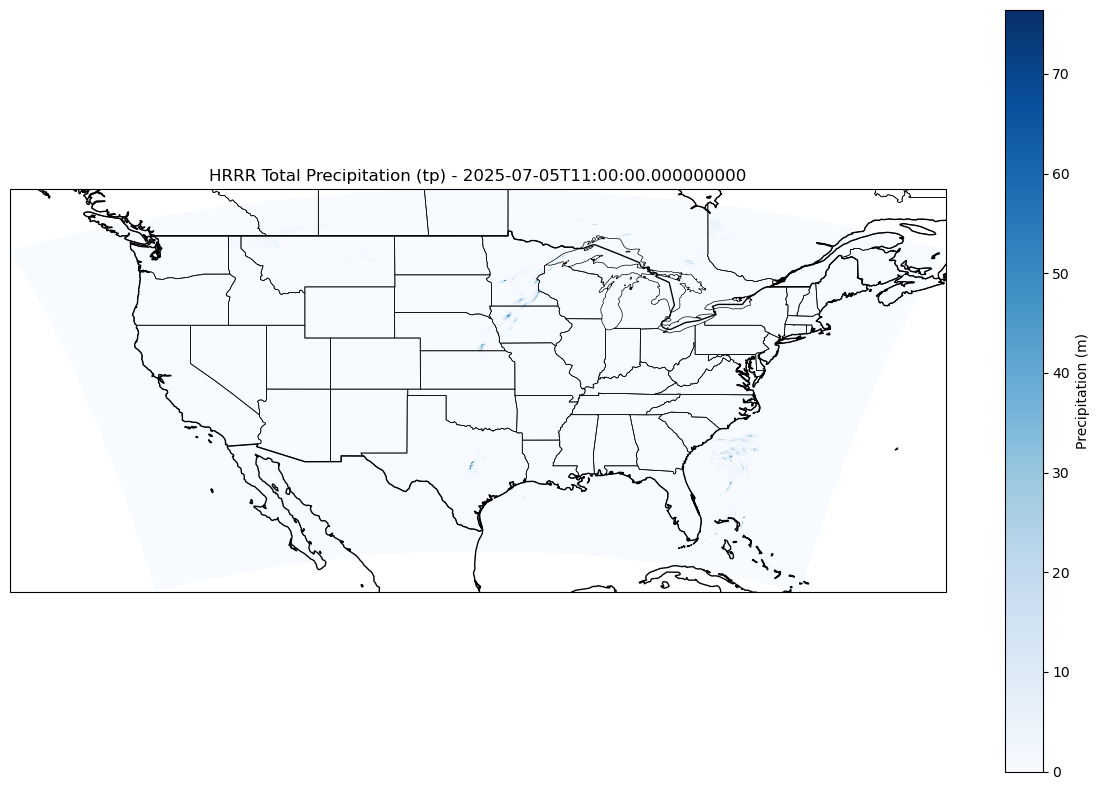

In [1]:


import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- File path ---
file_path = "/p/lustre2/lazin1/hrrr_conus_apcp_20250701_20250710/HRRR_APCP_CONUS_20250705_10.grib2"  # Replace with your actual path

# --- Open GRIB2 file with cfgrib engine ---
ds = xr.open_dataset(file_path, engine="cfgrib")

# --- Extract data ---
precip = ds['tp']  # total precipitation in meters
lats = ds['latitude']
lons = ds['longitude']

# --- Plot ---
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lons, lats, precip, transform=ccrs.PlateCarree(), cmap='Blues')
plt.colorbar(cf, label='Precipitation (m)')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.set_title(f"HRRR Total Precipitation (tp) - {str(ds.valid_time.values)}")
plt.tight_layout()
plt.show()



EPSG:4326


/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


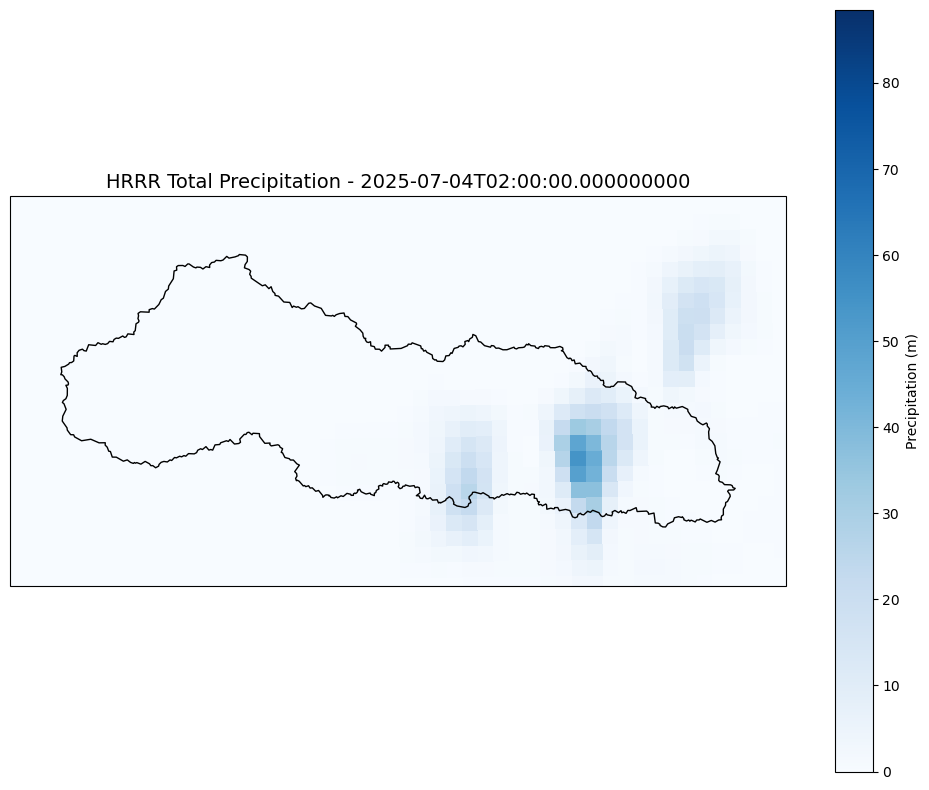

In [13]:
import os
import pyproj

# Explicitly point to the PROJ directory
proj_path = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/share/proj"
os.environ["PROJ_LIB"] = proj_path
os.environ["PYPROJ_GLOBAL_CONTEXT"] = "data"

# Set the data directory for pyproj explicitly
pyproj.datadir.set_data_dir(proj_path)

# Optional: verify
from pyproj import CRS
print(CRS.from_epsg(4326))  # ✅ should now succeed



import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# --- File paths ---
grib_path = "/p/lustre2/lazin1/hrrr_conus_apcp_20250701_20250710/HRRR_APCP_CONUS_20250704_01.grib2"
shapefile_path = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/Guadalupe_River.shp"

# --- Load precipitation ---
ds = xr.open_dataset(grib_path, engine="cfgrib")
precip = ds['tp']  # Total precipitation (m)
lats = ds['latitude']
lons = ds['longitude']

# --- Load shapefile ---
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs("EPSG:4326")  # Ensure it's in WGS84 for plotting

# --- Get bounding box of shapefile with small buffer ---
buffer_deg = 0.1  # degrees
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
lon_min, lat_min, lon_max, lat_max = (
    bounds[0] - buffer_deg, bounds[1] - buffer_deg,
    bounds[2] + buffer_deg, bounds[3] + buffer_deg
)

# --- Plot ---
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

cf = ax.pcolormesh(lons, lats, precip, transform=ccrs.PlateCarree(), cmap='Blues')
plt.colorbar(cf, ax=ax, label='Precipitation (m)')

# Add shapefile overlay
gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Add geographic features
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Add title
valid_time = str(ds.valid_time.values) if 'valid_time' in ds else 'Unknown'
ax.set_title(f"HRRR Total Precipitation - {valid_time}", fontsize=14)

plt.tight_layout()
plt.show()


In [19]:
import os, glob, json
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from rasterio.transform import from_bounds
from datetime import datetime, timedelta
from tqdm import tqdm

events_file = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/guadalupe_river.csv"
combined_df = pd.read_csv(events_file) 
start_dates = combined_df['start'].to_numpy()
end_dates = combined_df['end'].to_numpy()

# HRRR GRIB2 data folder
input_dir = "/p/lustre2/lazin1/hrrr_conus_apcp_20250701_20250710"

# Define bounding box (Guadalupe River region)
lat_min, lat_max = 29.75, 30.37
lon_min, lon_max = -99.8, -98.34

for idx, (s, e) in enumerate(zip(start_dates, end_dates)):
    print(f"⏳ Processing event {idx+1}: {s} to {e}")

    start_dt = datetime.strptime(s + " 00", "%Y-%m-%d %H")
    end_dt = datetime.strptime(e + " 23", "%Y-%m-%d %H")
    start_date = start_dt.strftime("%Y-%m-%d %H")
    end_date = end_dt.strftime("%Y-%m-%d %H")

    grib_files = sorted(glob.glob(os.path.join(input_dir, f"HRRR_APCP_CONUS_2025*.grib2")))
    
    bands = []
    lat, lon = None, None

    for file in tqdm(grib_files, desc=f"Event {idx+1}: Reading GRIB2"):
        ds = xr.open_dataset(file, engine='cfgrib')

        # Get precipitation variable
        if "tp" in ds:
            precip = ds["tp"]
        elif "APCP_surface" in ds:
            precip = ds["APCP_surface"]
        else:
            varname = list(ds.data_vars)[0]
            precip = ds[varname]

        # Extract single timestep
        if "time" in precip.dims:
            precip = precip.isel(time=0)

        data = precip.values
        # data = np.flipud(data)
        # data = data.isel(latitude=slice(None, None, -1)) 

        if lat is None or lon is None:
            lat = ds.latitude.values
            lon = ds.longitude.values
            lon = np.where(lon > 180, lon - 360, lon)

        bands.append(data)

    bands = np.stack(bands, axis=0)
    
    
    

    # Crop to ROI (row/col slicing)
    # Flatten and mask using geographic bounding box
    mask = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)

    # Get the bounding rows and cols (row/col of True values)
    rows, cols = np.where(mask)

    if rows.size == 0 or cols.size == 0:
        raise ValueError("No grid points found within the specified lat/lon bounds.")

    # Define crop bounds in index space
    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()

    # Crop the bands using row/col slices
    cropped = bands[:, row_min:row_max+1, col_min:col_max+1]

    # Use corresponding lat/lon slices
    lat_cropped = lat[row_min:row_max+1, col_min:col_max+1]
    lon_cropped = lon[row_min:row_max+1, col_min:col_max+1]


    # Flip latitude if increasing
    if np.all(np.diff(lat_cropped) > 0):
        print("FLIPPING along lat")
        cropped = cropped[:, ::-1, :]
        lat_cropped = lat_cropped[::-1]

    # Create GeoTIFF transform
    height, width = cropped.shape[1:]
    from rasterio.transform import from_bounds

    lat_min_val = np.min(lat_cropped)
    lat_max_val = np.max(lat_cropped)
    lon_min_val = np.min(lon_cropped)
    lon_max_val = np.max(lon_cropped)

    transform = from_bounds(
        west=lon_min_val, south=lat_min_val,
        east=lon_max_val, north=lat_max_val,
        width=cropped.shape[2], height=cropped.shape[1]
)


    output_tif = f"/p/lustre2/lazin1/Guadalupe_River/precip_HRRR_GuadalupeRiver_{s}_{e}.tif"
    with rasterio.open(
        output_tif, 'w',
        driver='GTiff',
        height=height,
        width=width,
        count=cropped.shape[0],
        dtype=cropped.dtype,
        crs='EPSG:4326',
        transform=transform
    ) as dst:
        for i in range(cropped.shape[0]):
            dst.write(cropped[i], i + 1)

    print(f"✅ Saved GeoTIFF: {output_tif}")

    # Load base config and modify
    with open('base.json', "r") as f:
        config = json.load(f)

    total_seconds = (end_dt - start_dt).total_seconds()
    time_step_seconds = config["time-step-seconds"]
    config["max-steps"] = int(total_seconds / time_step_seconds)
    config["rain-multiband-geotiff"]["filename"] = f"/usr/workspace/lazin1/Codes/torent/precip_HRRR_GuadalupeRiver_{s}_{e}.tif"
    config["rain-multiband-geotiff"]["max-index"] = cropped.shape[0]

    out_dir = f"/p/lustre1/lazin1/flood/Texas/GuadalupeRiver_{s}_{e}/"
    config["output-directory"] = out_dir
    os.makedirs(out_dir, exist_ok=True)

    updated_config_file = f"{out_dir}/GuadalupeRiver_{s}_{e}.json"
    with open(updated_config_file, "w") as f:
        json.dump(config, f, indent=2)

    print(f"📝 Config updated: {updated_config_file}")

    # Modify Julia script
    with open("/usr/workspace/lazin1/Codes/torent/test_file.jl", "r") as file:
        lines = file.readlines()

    for i, line in enumerate(lines):
        if "FILENAME" in line:
            lines[i] = line.replace("FILENAME", updated_config_file)

    with open(f"run_event_guadalupe_{idx+1}.jl", "w") as file:
        file.writelines(lines)

    # SLURM script
    slurm_script = f"""#!/bin/bash -l
#SBATCH -N 1
#SBATCH -p pbatch
#SBATCH -t 12:00:00
#SBATCH -o %A-flood.out
#SBATCH -A flood

source /usr/workspace/lazin1/anaconda_dane/etc/profile.d/conda.sh
conda activate /usr/workspace/lazin1/anaconda_dane/envs/julia/

julia --threads 8 run_event_guadalupe_{idx+1}.jl &
wait
"""
    with open(f"submit_guadalupe_event{idx+1}.sh", "w") as f:
        f.write(slurm_script)

    os.chmod(f"submit_guadalupe_event{idx+1}.sh", 0o755)
    print(f"🚀 SLURM script ready: submit_guadalupe_event{idx+1}.sh")


⏳ Processing event 1: 2025-07-02 to 2025-07-06


Event 1: Reading GRIB2:   0%|          | 0/240 [00:00<?, ?it/s]/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Event 1: Reading GRIB2:   1%|          | 2/240 [00:00<00:12, 19.75it/s]/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a futur

FLIPPING along lat
✅ Saved GeoTIFF: /p/lustre2/lazin1/Guadalupe_River/precip_HRRR_GuadalupeRiver_2025-07-02_2025-07-06.tif


FileNotFoundError: [Errno 2] No such file or directory: 'base.json'

# filter time

In [22]:
import os, glob, json
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from rasterio.transform import from_bounds
from datetime import datetime
from tqdm import tqdm

# === Input CSV with events ===
events_file = "/usr/workspace/lazin1/anaconda_dane/envs/RAPID/Codes/Guadalupe_River/guadalupe_river.csv"
combined_df = pd.read_csv(events_file)
start_dates = combined_df['start'].to_numpy()
end_dates = combined_df['end'].to_numpy()

# === HRRR GRIB2 data folder ===
input_dir = "/p/lustre2/lazin1/hrrr_conus_apcp_20250701_20250710"

# === Bounding box for Guadalupe River ===
lat_min, lat_max = 29.75, 30.37
lon_min, lon_max = -99.8, -98.34

# === Event Loop ===
for idx, (s, e) in enumerate(zip(start_dates, end_dates)):
    print(f"⏳ Processing event {idx+1}: {s} to {e}")

    start_dt = datetime.strptime(s + " 00", "%Y-%m-%d %H")
    end_dt = datetime.strptime(e + " 23", "%Y-%m-%d %H")
    start_date = start_dt.strftime("%Y-%m-%d %H")
    end_date = end_dt.strftime("%Y-%m-%d %H")

    grib_files = sorted(glob.glob(os.path.join(input_dir, f"HRRR_APCP_CONUS_2025*.grib2")))

    precip_list = []
    lat, lon = None, None

    for file in tqdm(grib_files, desc=f"Event {idx+1}: Reading GRIB2"):
        ds = xr.open_dataset(file, engine='cfgrib')

        # Extract precipitation variable
        if "tp" in ds:
            precip = ds["tp"]
        elif "APCP_surface" in ds:
            precip = ds["APCP_surface"]
        else:
            precip = ds[list(ds.data_vars)[0]]

        if "time" in precip.dims:
            precip = precip.isel(time=0)

        precip_list.append(precip)

    # Combine, deduplicate, filter
    precip = xr.concat(precip_list, dim="time")
    _, index = np.unique(precip["time"], return_index=True)
    precip = precip.isel(time=index)
    precip = precip.sel(time=slice(start_date, end_date))
    precip = precip.fillna(0)

    # Get lat/lon
    lat = precip.latitude.values
    lon = precip.longitude.values
    lon = np.where(lon > 180, lon - 360, lon)

    lat_diff = np.diff(lat[:, 0])
    # if np.all(lat_diff >= 0):
    #     print("FLIPPING along lat")
    #     precip = precip.isel(latitude=slice(None, None, -1))
    #     lat = lat[::-1, :]
    #     lon = lon[::-1, :]
        
        
    

    bands = precip.values

    # Crop
    mask = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)
    rows, cols = np.where(mask)
    if rows.size == 0 or cols.size == 0:
        raise ValueError("No grid points found within the specified lat/lon bounds.")

    row_min, row_max = rows.min(), rows.max()
    col_min, col_max = cols.min(), cols.max()

    cropped = bands[:, row_min:row_max+1, col_min:col_max+1]
    lat_cropped = lat[row_min:row_max+1, col_min:col_max+1]
    lon_cropped = lon[row_min:row_max+1, col_min:col_max+1]
    
    
    
    # Flip latitude if increasing
    if np.all(np.diff(lat_cropped) > 0):
        print("FLIPPING along lat")
        cropped = cropped[:, ::-1, :]
        lat_cropped = lat_cropped[::-1]

    height, width = cropped.shape[1:]
    lat_min_val = np.min(lat_cropped)
    lat_max_val = np.max(lat_cropped)
    lon_min_val = np.min(lon_cropped)
    lon_max_val = np.max(lon_cropped)

    transform = from_bounds(west=lon_min_val, south=lat_min_val,
                            east=lon_max_val, north=lat_max_val,
                            width=width, height=height)

    output_tif = f"/p/lustre2/lazin1/Guadalupe_River/precip_HRRR_GuadalupeRiver_{s}_{e}.tif"
    with rasterio.open(output_tif, 'w', driver='GTiff', height=height, width=width,
                       count=cropped.shape[0], dtype=cropped.dtype, crs='EPSG:4326',
                       transform=transform) as dst:
        for i in range(cropped.shape[0]):
            dst.write(cropped[i], i + 1)

    print(f"✅ Saved GeoTIFF: {output_tif}")

    # Update base config
    with open('base.json', "r") as f:
        config = json.load(f)

    total_seconds = (end_dt - start_dt).total_seconds()
    config["max-steps"] = int(total_seconds / config["time-step-seconds"])
    config["rain-multiband-geotiff"]["filename"] = f"/usr/workspace/lazin1/Codes/torent/precip_HRRR_GuadalupeRiver_{s}_{e}.tif"
    config["rain-multiband-geotiff"]["max-index"] = cropped.shape[0]

    out_dir = f"/p/lustre1/lazin1/flood/Texas/GuadalupeRiver_{s}_{e}/"
    config["output-directory"] = out_dir
    os.makedirs(out_dir, exist_ok=True)

    updated_config_file = f"{out_dir}/GuadalupeRiver_{s}_{e}.json"
    with open(updated_config_file, "w") as f:
        json.dump(config, f, indent=2)

    print(f"📝 Config updated: {updated_config_file}")

    # Julia script
    with open("/usr/workspace/lazin1/Codes/torent/test_file.jl", "r") as file:
        lines = file.readlines()

    for i, line in enumerate(lines):
        if "FILENAME" in line:
            lines[i] = line.replace("FILENAME", updated_config_file)

    with open(f"run_event_guadalupe_{idx+1}.jl", "w") as file:
        file.writelines(lines)

    # SLURM script
    slurm_script = f"""#!/bin/bash -l
#SBATCH -N 1
#SBATCH -p pbatch
#SBATCH -t 12:00:00
#SBATCH -o %A-flood.out
#SBATCH -A flood

source /usr/workspace/lazin1/anaconda_dane/etc/profile.d/conda.sh
conda activate /usr/workspace/lazin1/anaconda_dane/envs/julia/

julia --threads 8 run_event_guadalupe_{idx+1}.jl &
wait
"""
    with open(f"submit_guadalupe_event{idx+1}.sh", "w") as f:
        f.write(slurm_script)

    os.chmod(f"submit_guadalupe_event{idx+1}.sh", 0o755)
    print(f"🚀 SLURM script ready: submit_guadalupe_event{idx+1}.sh")



⏳ Processing event 1: 2025-07-02 to 2025-07-06


Event 1: Reading GRIB2:   0%|          | 0/240 [00:00<?, ?it/s]

/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, Fa

FLIPPING along lat
✅ Saved GeoTIFF: /p/lustre2/lazin1/Guadalupe_River/precip_HRRR_GuadalupeRiver_2025-07-02_2025-07-06.tif


FileNotFoundError: [Errno 2] No such file or directory: 'base.json'

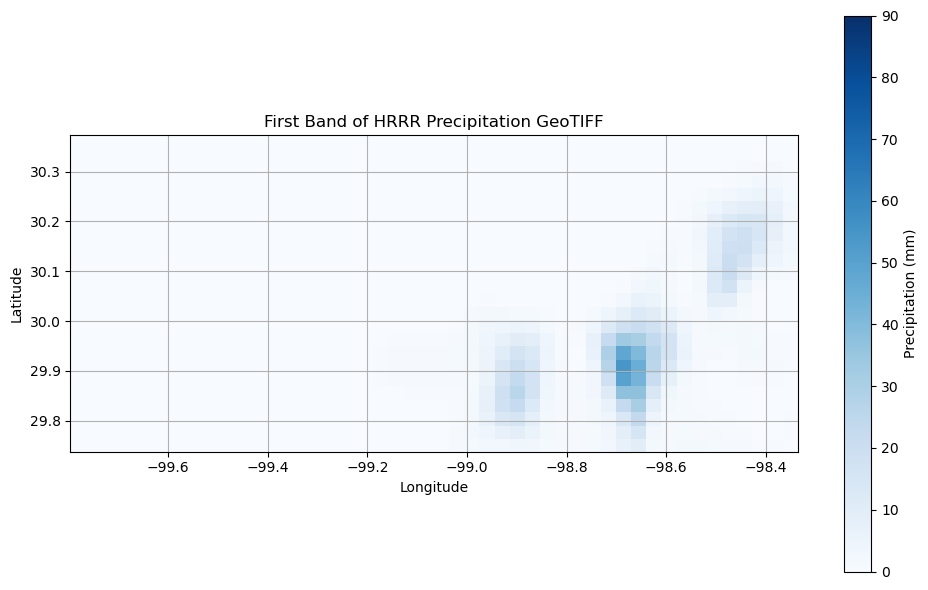

In [24]:
import rasterio
import matplotlib.pyplot as plt

# Path to your GeoTIFF file
tif_path = "/p/lustre2/lazin1/Guadalupe_River/precip_HRRR_GuadalupeRiver_2025-07-02_2025-07-06.tif"

# Open the GeoTIFF
with rasterio.open(tif_path) as src:
    band1 = src.read(50)  # Read the first band
    transform = src.transform

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(band1, cmap='Blues', extent=(
    transform.c, transform.c + transform.a * src.width,
    transform.f + transform.e * src.height, transform.f
    
), vmin=0, vmax=90)
plt.colorbar(label="Precipitation (mm)")
plt.title("First Band of HRRR Precipitation GeoTIFF")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import xarray as xr
import numpy as np
import rasterio
from rasterio.transform import from_origin
import glob
import os
from tqdm import tqdm

# === Parameters ===
input_dir = "/p/lustre2/lazin1/hrrr_conus_apcp_20250701_20250710"
output_file = "/p/lustre2/lazin1/hrrr_conus_apcp_20250701_20250710/HRRR_APCP_20250701_20250710_multiband.tif"

# === Get sorted GRIB2 files ===
grib_files = sorted(glob.glob(os.path.join(input_dir, "HRRR_APCP_CONUS_202507*.grib2")))

# === Read and process all bands ===
bands = []
lat, lon = None, None

for file in tqdm(grib_files, desc="Processing GRIB2 files"):
    ds = xr.open_dataset(file, engine='cfgrib')

    # Select precipitation variable
    if "tp" in ds:
        precip = ds["tp"]
    elif "APCP_surface" in ds:
        precip = ds["APCP_surface"]
    else:
        varname = list(ds.data_vars)[0]
        precip = ds[varname]

    # Extract 2D array
    if "time" in precip.dims:
        precip = precip.isel(time=0)

    data = precip.values

Processing GRIB2 files:   0%|          | 0/240 [00:00<?, ?it/s]/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)
/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
Processing GRIB2 files:   0%|          | 1/240 [00:05<22:42,  5.70s/it]/usr/workspace/lazin1/anaconda_dane/envs/RAPID/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instanc

In [5]:
    # Flip lat if needed
    if lat is None:
        lat = ds.latitude.values
        lon = ds.longitude.values
        flip = np.all(np.diff(lat) < 0)

In [10]:
lat[1] - lat[0]

array([0.02487159, 0.02487446, 0.02487734, ..., 0.02487833, 0.02487546,
       0.02487258])